In [98]:
import os, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandasql import sqldf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import euclidean_distances
from mpl_toolkits.mplot3d import Axes3D

rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

import scripts.read_data_from_db as rd
import scripts.data_cleaning as dc
import scripts.write_to_db as wd
import scripts.utils as util

In [2]:
experience_df = rd.read_data(table_name='user_experience')
engagement_df = rd.read_data(table_name='user_engagement')

INFO:scripts.read_data_from_db:Data fetched succesfully
INFO:scripts.read_data_from_db:Data fetched succesfully


In [70]:
pysqldf = lambda q: sqldf(q, globals())

In [3]:
experience_df.head()

,CustomerID,AvgTCP,AvgRTT,AvgThroughput
0,3.360100e+10,1.000000,0.163896,0.000268
1,3.360100e+10,1.000000,0.028926,0.000349
2,3.360100e+10,1.000000,0.427515,0.000342
3,3.360101e+10,1.000000,0.247934,0.000873
4,3.360101e+10,0.717138,0.183188,0.100102


In [4]:
engagement_df.head()

,MSISDN/Number,SessionDuration,SessionFrequency,TotalTraffic
0,3.360100e+10,0.001349,0.000000,0.001568
1,3.360100e+10,0.002143,0.000000,0.000229
2,3.360100e+10,0.001574,0.000000,0.001044
3,3.360101e+10,0.000526,0.000000,0.000722
4,3.360101e+10,0.000369,0.001927,0.002641


In [50]:
merged_df = engagement_df.merge(experience_df, left_on='MSISDN/Number', right_on="CustomerID", how='inner')
merged_df.head()

,MSISDN/Number,SessionDuration,SessionFrequency,TotalTraffic,EngagementScore,CustomerID,AvgTCP,AvgRTT,AvgThroughput
0,3.360100e+10,0.001349,0.000000,0.001568,0.002365,3.360100e+10,1.000000,0.163896,0.000268
1,3.360100e+10,0.002143,0.000000,0.000229,0.002696,3.360100e+10,1.000000,0.028926,0.000349
2,3.360100e+10,0.001574,0.000000,0.001044,0.002399,3.360100e+10,1.000000,0.427515,0.000342
3,3.360101e+10,0.000526,0.000000,0.000722,0.002912,3.360101e+10,1.000000,0.247934,0.000873
4,3.360101e+10,0.000369,0.001927,0.002641,0.001972,3.360101e+10,0.717138,0.183188,0.100102


### Handle Outliers

In [5]:
experience_columns = ["AvgTCP","AvgRTT","AvgThroughput"]
engagement_columns = ["SessionDuration","SessionFrequency","TotalTraffic"]

In [51]:
merged_df = dc.handle_outliers(merged_df, engagement_columns)
merged_df = dc.handle_outliers(merged_df, experience_columns)

### Assigning scores

In [80]:
k = 3
X_eng = merged_df[engagement_columns]
X_exp = merged_df[experience_columns]

##### Assign engagement score

In [81]:
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_eng)

less_engaged_cluster = pd.Series(cluster_labels).value_counts().idxmin()
less_engaged_cluster_center = kmeans.cluster_centers_[less_engaged_cluster]

distances = euclidean_distances(X_eng, [less_engaged_cluster_center]).flatten()
merged_df['EngagementScore'] =  distances
merged_df.head()


,MSISDN/Number,SessionDuration,SessionFrequency,TotalTraffic,EngagementScore,CustomerID,AvgTCP,AvgRTT,AvgThroughput,ExperienceScore,SatisfactionScore
0,3.360100e+10,0.001349,0.000000,0.001568,0.001966,3.360100e+10,1.000000,0.163896,0.000268,0.283794,0.142880
1,3.360100e+10,0.002143,0.000000,0.001140,0.001997,3.360100e+10,1.000000,0.237398,0.000349,0.283513,0.142755
2,3.360100e+10,0.001574,0.000000,0.001044,0.001974,3.360100e+10,1.000000,0.427515,0.000342,0.283802,0.142888
3,3.360101e+10,0.000526,0.000000,0.000722,0.002381,3.360101e+10,1.000000,0.247934,0.000873,0.284367,0.143374
4,3.360101e+10,0.000369,0.001927,0.001140,0.001386,3.360101e+10,0.717138,0.183188,0.100102,0.282708,0.142047


##### Assign Experience score

In [82]:
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_exp)

worst_experience_cluster = pd.Series(cluster_labels).value_counts().idxmin()
worst_experience_cluster_cluster_center = kmeans.cluster_centers_[worst_experience_cluster]

distances = euclidean_distances(X_eng, [worst_experience_cluster_cluster_center]).flatten()
merged_df['ExperienceScore'] =  distances
merged_df.head()

,MSISDN/Number,SessionDuration,SessionFrequency,TotalTraffic,EngagementScore,CustomerID,AvgTCP,AvgRTT,AvgThroughput,ExperienceScore,SatisfactionScore
0,3.360100e+10,0.001349,0.000000,0.001568,0.001966,3.360100e+10,1.000000,0.163896,0.000268,0.283794,0.142880
1,3.360100e+10,0.002143,0.000000,0.001140,0.001997,3.360100e+10,1.000000,0.237398,0.000349,0.283513,0.142755
2,3.360100e+10,0.001574,0.000000,0.001044,0.001974,3.360100e+10,1.000000,0.427515,0.000342,0.283802,0.142888
3,3.360101e+10,0.000526,0.000000,0.000722,0.002381,3.360101e+10,1.000000,0.247934,0.000873,0.284367,0.143374
4,3.360101e+10,0.000369,0.001927,0.001140,0.001386,3.360101e+10,0.717138,0.183188,0.100102,0.282708,0.142047


#### Satisfaction Score

In [83]:
merged_df['SatisfactionScore'] = (merged_df['EngagementScore'] + merged_df['ExperienceScore']) / 2
merged_df.head()

,MSISDN/Number,SessionDuration,SessionFrequency,TotalTraffic,EngagementScore,CustomerID,AvgTCP,AvgRTT,AvgThroughput,ExperienceScore,SatisfactionScore
0,3.360100e+10,0.001349,0.000000,0.001568,0.001966,3.360100e+10,1.000000,0.163896,0.000268,0.283794,0.142880
1,3.360100e+10,0.002143,0.000000,0.001140,0.001997,3.360100e+10,1.000000,0.237398,0.000349,0.283513,0.142755
2,3.360100e+10,0.001574,0.000000,0.001044,0.001974,3.360100e+10,1.000000,0.427515,0.000342,0.283802,0.142888
3,3.360101e+10,0.000526,0.000000,0.000722,0.002381,3.360101e+10,1.000000,0.247934,0.000873,0.284367,0.143374
4,3.360101e+10,0.000369,0.001927,0.001140,0.001386,3.360101e+10,0.717138,0.183188,0.100102,0.282708,0.142047


### Top satisfied users

In [84]:
query = ''' 
    SELECT 
        UserID,
        SatisfactionScore
    FROM df
    ORDER BY SatisfactionScore DESC
    LIMIT 10
'''

pysqldf(query)

,UserID,SatisfactionScore
0,3.369904e+10,0.143621
1,3.366484e+10,0.143620
2,3.376311e+10,0.143620
3,3.366490e+10,0.143620
4,3.365852e+10,0.143619
5,3.363214e+10,0.143619
6,3.362671e+10,0.143619
7,3.363083e+10,0.143619
8,3.369821e+10,0.143618
9,3.361199e+10,0.143617


### Linear Regression

In [89]:
features = engagement_columns + experience_columns
X = merged_df[features]
y = merged_df.SatisfactionScore

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression() 
model.fit(X_train, y_train)

y_pred  = model.predict(X_test)


### KMeans clustering

In [91]:
selected_columns = ["EngagementScore", "SatisfactionScore"]
X = merged_df[selected_columns]
k = 2

kmeans = KMeans(n_clusters=k, random_state=0, n_init=15) 
kmeans.fit(X)

merged_df['Cluster'] = kmeans.labels_

#### Clusters plot

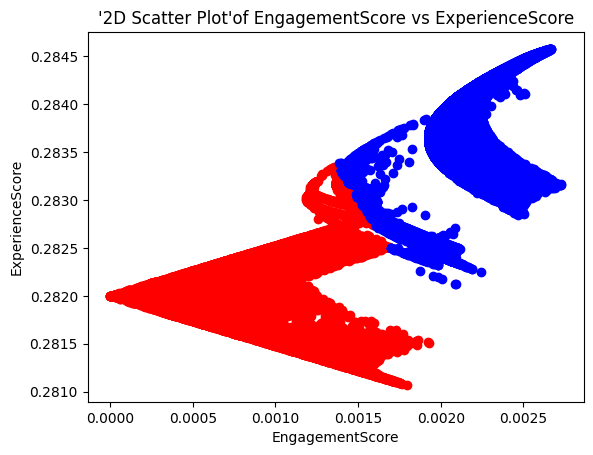

In [94]:
cluster_colors = {0: 'red', 1: 'blue'}
for cluster_label, color in cluster_colors.items():
    cluster_df = merged_df[merged_df["Cluster"] == cluster_label]
    plt.scatter(cluster_df["EngagementScore"], cluster_df["ExperienceScore"], c=color)


plt.xlabel("EngagementScore")
plt.ylabel("ExperienceScore")
plt.title("'2D Scatter Plot'of EngagementScore vs ExperienceScore")

plt.show()

### Average Satisfaction per cluster


In [96]:
query = ''' 
    SELECT 
        cluster,
        AVG("SatisfactionScore") As "Average Satisfaction"
    FROM merged_df 
    GROUP BY cluster;
'''
avg_satsifaction = pysqldf(query)
avg_satsifaction

,Cluster,Average Satisfaction
0,0,0.141526
1,1,0.143009


### Average experience Score per cluster

In [97]:
query = ''' 
    SELECT 
        cluster,
        AVG("ExperienceScore") AS "Average Experience" 
    FROM merged_df 
    GROUP BY cluster 
'''

avg_experience = pysqldf(query)
avg_experience

,Cluster,Average Experience
0,0,0.282194
1,1,0.283899


In [101]:
df = pd.DataFrame({
    "UserID": merged_df["CustomerID"],
    "SatisfactionScore": merged_df["SatisfactionScore"],
    "ExperienceScore": merged_df["ExperienceScore"],
    "EngagementScore": merged_df["EngagementScore"]
})

wd.write_data(df, "satisfaction_score")

INFO:scripts.write_to_db:Data written successfully
